# 코스피 산업군 군집분석 결과에 따른 주택매매가격지수와의 상관관계 분석

<p align="center">
  <img src="https://user-images.githubusercontent.com/55734436/119505218-b3489a80-bda7-11eb-8eac-24a1a3cd167e.png" alt="factorio thumbnail"/>
</p> 

출처: https://www.edaily.co.kr/news/read?newsId=01748246629018744&cateNo=&mediaCodeNo=257

밀리의 서재(전자책 구독 서비스)에서 인기 검색어를 분석한 결과 **‘주식’**이 1월부터 3월까지 모두 1위를 하였습니다. 또한 **‘부동산’**은 1월 13위에서 2월 8위, 3월 6위로 순위가 상승하였습니다. 


이슈가 되고 있는 **주식**, **부동산** 데이터를 바탕으로   

**"부동산 가격 추세를 가장 유사하게 추종하는 KOSPI 산업군 그룹은 무엇일까?"** 라는 주제를 가지고 데이터 분석을 진행하였습니다.

## 사용 데이터

**데이콘 제공 데이터**  

- 주택매매가격지수(KB).csv  

**외부 데이터**  

- 전체 코스피 지수: [KRX 정보데이터시스템](http://data.krx.co.kr/contents/MDC/MAIN/main/index.cmd)  

- 산업별 코스피 지수: [KOSIS 국가통계포털](https://kosis.kr/statHtml/statHtml.do?orgId=343&tblId=DT_343_2010_S0190&vw_cd=&list_id=00000133&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=R1&path=)

코스피는 크게 22개의 산업군으로 나누어집니다. 22개의 목록은 다음과 같습니다.  

|  | | 
|:--------|:--------:|
|제조업| 음식료품 | 
|섬유의복| 종이목재 |
|화학| 의약품 |
|비금속광물| 철강금속 |
|기계| 전기전자 |
|의료정밀| 운수장비 |
|유통업| 전기가스업 |
|건설업| 운수창고업 |
|통신업| 금융업 |
|은행| 증권 |
|보험| 서비스업 |



군집분석을 통해 산업군의 군집을 파악하고 부동산 가격 추세를 가장 유사하게 추종하는 KOSPI 산업군 그룹을 파악하고자 합니다.

In [1]:
# 필요 패키지 설치
!pip install tslearn
!pip install kneed

In [2]:
!pip install plotly

In [95]:
from sklearn.preprocessing import StandardScaler

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from plotly.subplots import make_subplots
from matplotlib import rc
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

import matplotlib.pyplot as plt

rc('font', family='AppleGothic')

import seaborn as sns
plt.style.use('ggplot')

from kneed import KneeLocator

from datetime import date
import numpy as np
import pandas as pd
import random

import warnings
warnings.filterwarnings('ignore')

In [7]:
kospi = pd.read_csv("./코스피_산업별_주가지수.csv", encoding = "CP949")
kospi.head()

,날짜,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
0,2000-01-01,1186.95,1140.02,355.40,381.45,797.70,964.28,500.98,1477.68,399.13,...,287.89,961.33,101.24,726.69,809.01,328.16,160.37,2315.58,3397.18,760.89
1,2000-02-01,1051.13,1064.90,350.45,327.25,716.03,1264.12,411.56,1254.39,378.20,...,240.64,811.02,77.23,673.50,753.98,253.12,112.39,1906.11,2812.40,952.39
2,2000-03-01,1196.83,1074.09,375.93,354.76,755.94,1201.82,435.58,1225.27,346.24,...,265.52,898.48,74.70,733.95,703.72,213.12,104.76,1397.07,2451.53,810.17
3,2000-04-01,1017.99,911.25,313.76,305.77,624.65,997.37,411.75,998.09,279.67,...,221.81,903.47,69.75,550.21,540.78,180.92,101.69,987.68,1947.97,655.84
4,2000-05-01,979.88,771.48,250.99,230.29,527.90,873.13,360.92,977.54,239.36,...,187.06,842.20,62.24,433.71,643.54,185.72,103.74,1072.90,2118.68,630.57


In [8]:
# 날짜를 인덱스로 변경
kospi = kospi.set_index('날짜')
kospi = pd.DataFrame(kospi)
kospi.head()

,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,전기전자,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
날짜,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1186.95,1140.02,355.40,381.45,797.70,964.28,500.98,1477.68,399.13,4250.02,...,287.89,961.33,101.24,726.69,809.01,328.16,160.37,2315.58,3397.18,760.89
2000-02-01,1051.13,1064.90,350.45,327.25,716.03,1264.12,411.56,1254.39,378.20,3704.27,...,240.64,811.02,77.23,673.50,753.98,253.12,112.39,1906.11,2812.40,952.39
2000-03-01,1196.83,1074.09,375.93,354.76,755.94,1201.82,435.58,1225.27,346.24,4655.30,...,265.52,898.48,74.70,733.95,703.72,213.12,104.76,1397.07,2451.53,810.17
2000-04-01,1017.99,911.25,313.76,305.77,624.65,997.37,411.75,998.09,279.67,4009.41,...,221.81,903.47,69.75,550.21,540.78,180.92,101.69,987.68,1947.97,655.84
2000-05-01,979.88,771.48,250.99,230.29,527.90,873.13,360.92,977.54,239.36,3971.40,...,187.06,842.20,62.24,433.71,643.54,185.72,103.74,1072.90,2118.68,630.57


In [9]:
# 변수명 저장
column_name = kospi.columns
column_name

Index(['제조업', '음식료품', '섬유의복', '종이목재', '화학', '의약품', '비금속광물', '철강금속', '기계',
       '전기전자', '의료정밀', '운수장비', '유통업', '전기가스업', '건설업', '운수창고업', '통신업', '금융업',
       '은행', '증권', '보험', '서비스업'],
      dtype='object')

## 산업군별 코스피 지수 시각화

In [96]:
fig = go.Figure()

for category in column_name:
    fig.add_trace(go.Scatter(y=kospi[category], mode = 'lines', name = category))

fig.show()

정확한 추세 비교를 위해 정규화를 진행 후 다시 시각화를 진행하였습니다.

### 정규화 진행 후 산업군별 코스피 시각화

In [97]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

fig = go.Figure()

for category in column_name:
    kospi[category] = scaler.fit_transform(pd.DataFrame(kospi[category]))
    fig.add_trace(go.Scatter(y=kospi[category], mode='lines', name=category))
    
fig.show()

## 군집분석(euclidean 사용) 

In [89]:
# 군집분석을 위한 형태로 변형
kospi2 = to_time_series_dataset(kospi.values.T)

### 군집개수 설정을 위한 분석

In [90]:
value = []

for k in range(1, 8):
    model = TimeSeriesKMeans(n_clusters=k, metric='euclidean', verbose=False, random_state=42)
    model.fit(kospi2)
    value.append(model.inertia_)
    print(f'군집 수 {k}개 일때 Inertia value: {value[-1]}')

군집 수 1개 일때 Inertia value: 120.47140586709607
군집 수 2개 일때 Inertia value: 76.30313876284394
군집 수 3개 일때 Inertia value: 58.36152555998183
군집 수 4개 일때 Inertia value: 48.83906683529539
군집 수 5개 일때 Inertia value: 41.85136599893065
군집 수 6개 일때 Inertia value: 33.7180627307026
군집 수 7개 일때 Inertia value: 26.81074642446699


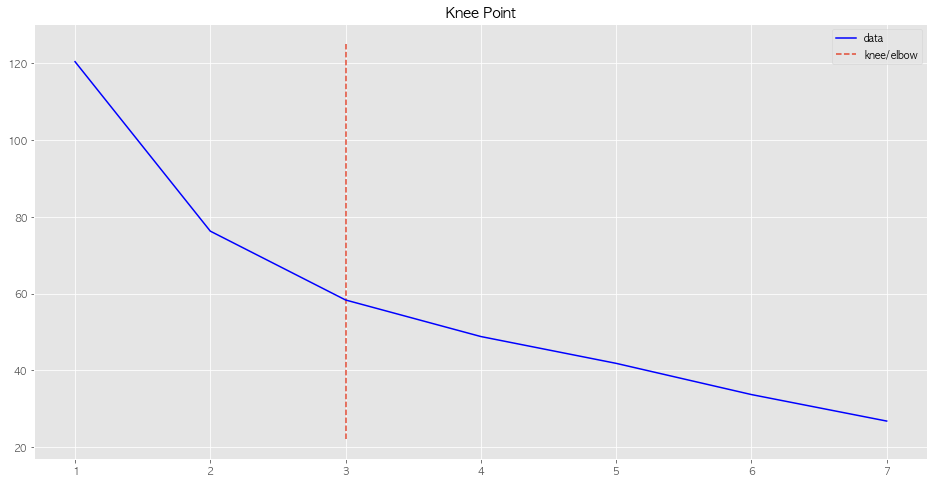

In [91]:
knee = KneeLocator(range(1, len(value)+1), value, curve='convex', direction='decreasing', online=True)
knee.plot_knee(figsize=(16,8))

다음은 적절한 군집개수를 파악하는데 도움을 주는 그래프입니다. 기준은 그래프가 완만해지는 순간을 기준으로 합니다.

- 위 그래프 별과 군집 개수가 3일때부터 완만해짐을 알 수 있습니다. 따라서 군집 개수가 3개가 적당해 보입니다.

### 군집분석 진행(k=3)

In [92]:
euclidean_k3 = TimeSeriesKMeans(n_clusters=3, metric='euclidean', verbose=True, random_state=42)
euclidean_k3_label = euclidean_k3.fit_predict(kospi2)

101.477 --> 65.978 --> 60.546 --> 58.362 --> 58.362 --> 


In [98]:
fig = go.Figure()

plot_names = []
buttons = []
states = []

cluster_value = np.unique(euclidean_k3_label)
default_cluster = "군집 1"

for i in range(len(cluster_value)):
    for cluster_i in np.argwhere(euclidean_k3_label == cluster_value[i]): # 각 클러스터에 해당하는 위치 찾기
        fig.add_trace(go.Scatter(x=kospi.iloc[:, cluster_i].index, y=kospi.iloc[:, cluster_i].values.flatten(), 
                                 name=kospi.columns[cluster_i][0], 
                                 line=dict(color="gray"), 
                                 visible=(f'군집 {i+1}'== default_cluster)))
    fig.add_trace(go.Scatter(x=kospi.iloc[:, cluster_i].index, 
                             y=euclidean_k3.cluster_centers_[cluster_value[i]].flatten(), 
                             name=f'군집 {i+1} 중심', 
                             line=dict(color="Orange"), 
                             visible=(f'군집 {i+1}'== default_cluster)))
    plot_names.extend([f'군집 {i+1}']*(len(np.argwhere(euclidean_k3_label == cluster_value[i]))+1))

for j in range(len(cluster_value)):
    states.append(f'군집 {j+1}')
    buttons.append(dict(method='update',
                        label=f'군집 {j+1}',
                        args = [{'visible': [f'군집 {j+1}'==r for r in plot_names]}]))

fig.update_layout(title_text='K-Means_Euclidean_k3', showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": states.index(default_cluster), "showactive": True, "x": 0.5, "y": 1.15}])

fig.show()

버튼을 클릭하면 각 군집안에 포함된 산업군과 추세를 확인할 수 있습니다.

- 각 군집마다 추세의 특징이 존재함을 확인하였습니다.

### 군집 분석(k=4)

In [94]:
euclidean_k4 = TimeSeriesKMeans(n_clusters=4, metric='euclidean', verbose=True, random_state=42)
euclidean_k4_label = euclidean_k4.fit_predict(kospi2)

86.684 --> 56.455 --> 51.023 --> 48.839 --> 48.839 --> 


In [99]:
fig = go.Figure()

plot_names = []
buttons = []
states = []

cluster_value = np.unique(euclidean_k4_label)
default_cluster = "군집 1"

for i in range(len(cluster_value)):
    for cluster_i in np.argwhere(euclidean_k4_label == cluster_value[i]): # 각 클러스터에 해당하는 위치 찾기
        fig.add_trace(go.Scatter(x=kospi.iloc[:, cluster_i].index, y=kospi.iloc[:, cluster_i].values.flatten(), 
                                 name=kospi.columns[cluster_i][0], 
                                 line=dict(color="gray"), 
                                 visible=(f'군집 {i+1}'== default_cluster)))
    fig.add_trace(go.Scatter(x=kospi.iloc[:, cluster_i].index, 
                             y=euclidean_k4.cluster_centers_[cluster_value[i]].flatten(), 
                             name=f'군집 {i+1} 중심', 
                             line=dict(color="Orange"), 
                             visible=(f'군집 {i+1}'== default_cluster)))
    plot_names.extend([f'군집 {i+1}']*(len(np.argwhere(euclidean_k4_label == cluster_value[i]))+1))

for j in range(len(cluster_value)):
    states.append(f'군집 {j+1}')
    buttons.append(dict(method='update',
                        label=f'군집 {j+1}',
                        args = [{'visible': [f'군집 {j+1}'==r for r in plot_names]}]))

fig.update_layout(title_text='K-Means_Euclidean_k4', showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": states.index(default_cluster), "showactive": True, "x": 0.5, "y": 1.15}])

fig.show()

### PCA를 적용하여 군집이 잘 형성되었는지 확인

In [19]:
# 데이터 모양 변형
nsamle, nx, ny = kospi2.shape
kospi2_pca = kospi2.reshape((nsamle,nx*ny))

#### K=3

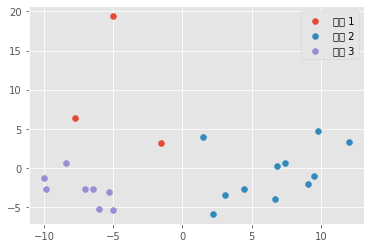

In [20]:
pca = PCA(n_components=2)  
pca_fit = pca.fit_transform(kospi2_pca)

for i in range(3):
  label_name = "군집 " +str(i+1)
  plt.scatter(pca_fit[[euclidean_k3_label==i]][:,0],pca_fit[[euclidean_k3_label==i]][:,1],label=label_name)

plt.legend()
plt.show()

#### K=4

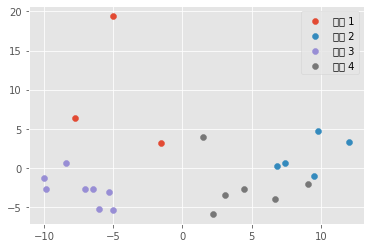

In [21]:
pca = PCA(n_components=2)  
pca_fit = pca.fit_transform(kospi2_pca)

for i in range(4):
  label_name = "군집 " +str(i+1)
  plt.scatter(pca_fit[[euclidean_k4_label==i]][:,0],pca_fit[[euclidean_k4_label==i]][:,1],label=label_name)

plt.legend()
plt.show()

- K=3, K=4일때를 비교해본 결과 K=3이 군집이 더 잘 형성됨을 보이므로 최종 군집 개수를 3개로 설정하였습니다.

군집분석 결과 각 군집별 중심값을 도출하였습니다. 이 중심값과 주택매매지수와의 상관분석을 진행하고자 합니다.

## 상관분석 진행을 위한 데이터셋 통합

In [22]:
# 군집별 중심값 데이터셋
c1 = pd.DataFrame(euclidean_k3.cluster_centers_[0], columns=['군집1_중심'])
c2 = pd.DataFrame(euclidean_k3.cluster_centers_[1], columns=['군집2_중심'])
c3 = pd.DataFrame(euclidean_k3.cluster_centers_[2], columns=['군집3_중심'])
center_result = pd.concat([c1,c2,c3],axis=1)
center_result.index = kospi.index
center_result

,군집1_중심,군집2_중심,군집3_중심
날짜,,,
2000-01-01,3.001572,-0.849940,-0.972535
2000-02-01,2.486401,-1.167639,-0.942972
2000-03-01,2.476201,-1.234568,-0.970734
2000-04-01,1.260472,-1.408181,-1.103688
2000-05-01,1.153880,-1.463478,-1.171049
...,...,...,...
2020-11-01,0.518109,-0.231509,1.932128
2020-12-01,0.415946,-0.094148,2.312603
2021-01-01,0.499006,-0.129882,2.473288


In [23]:
# 군집별 중심값 데이터셋 저장
center_result.to_csv("./center_cluster_result.csv")

In [24]:
# 산업군별 코스피 데이터와 군집별 중심값 데이터 통합  
result_data = pd.concat([center_result,kospi],axis=1)
result_data.head()

,군집1_중심,군집2_중심,군집3_중심,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
날짜,,,,,,,,,,,,,,,,,,,,,
2000-01-01,3.001572,-0.849940,-0.972535,-1.257398,-1.234981,1.512313,1.015728,-1.307052,-0.983268,-1.192945,...,-0.845365,-0.075241,-0.515999,-1.146584,6.476675,-0.672596,-1.127249,0.539378,-1.636147,-0.218858
2000-02-01,2.486401,-1.167639,-0.942972,-1.340759,-1.289411,1.454061,0.292311,-1.350913,-0.915108,-1.393847,...,-1.223488,-0.616328,-0.826617,-1.211101,5.712832,-1.314855,-1.769653,-0.032235,-1.732073,0.334471
2000-03-01,2.476201,-1.234568,-0.970734,-1.251334,-1.282753,1.753913,0.659491,-1.329480,-0.929270,-1.339880,...,-1.024383,-0.301488,-0.859347,-1.137778,5.015199,-1.657211,-1.871811,-0.742847,-1.791270,-0.076466
2000-04-01,1.260472,-1.408181,-1.103688,-1.361099,-1.400742,1.022288,0.005613,-1.399988,-0.975746,-1.393420,...,-1.374177,-0.283525,-0.923385,-1.360647,2.753514,-1.932808,-1.912916,-1.314348,-1.873873,-0.522394
2000-05-01,1.153880,-1.463478,-1.171049,-1.384490,-1.502016,0.283601,-1.001832,-1.451948,-1.003988,-1.507621,...,-1.652267,-0.504086,-1.020542,-1.501957,4.179872,-1.891725,-1.885468,-1.195383,-1.845870,-0.595411


In [25]:
# result_data 형식 변형
result_data2 = pd.melt(result_data,ignore_index=False)
result_data2

,variable,value
날짜,,
2000-01-01,군집1_중심,3.001572
2000-02-01,군집1_중심,2.486401
2000-03-01,군집1_중심,2.476201
2000-04-01,군집1_중심,1.260472
2000-05-01,군집1_중심,1.153880
...,...,...
2020-11-01,서비스업,2.127198
2020-12-01,서비스업,2.320473
2021-01-01,서비스업,2.647500


In [26]:
# 데이터 컬럼명 변경
result_data2 = result_data2.rename(columns = {'variable':'산업구분', 'value':'값'})
result_data2.head()

,산업구분,값
날짜,,
2000-01-01,군집1_중심,3.001572
2000-02-01,군집1_중심,2.486401
2000-03-01,군집1_중심,2.476201
2000-04-01,군집1_중심,1.260472
2000-05-01,군집1_중심,1.153880


In [27]:
# 군집분석 결과를 바탕으로 나온 각 군집별 산업군 목록을 정의
cluster_1 = ['섬유의복','종이목재','통신업','군집1_중심']
cluster_2 = ['철강금속','기계','운수장비','유통업','전기가스업','건설업','운수창고업','금융업','은행','증권','보험', '군집2_중심']
cluster_3 = ['제조업','음식료품','화학','의약품','비금속광물','전기전자','의료정밀','서비스업', '군집3_중심']

In [28]:
# 군집구분 컬럼 추가를 위한 함수
def cluster(type):
    if type in cluster_1: return '군집1'
    elif type in cluster_2: return '군집2'
    else: return '군집3'

result_data2['군집구분'] = result_data2.apply(lambda x: cluster(x['산업구분']),axis=1)

In [29]:
# 군집1 확인
result_data2[result_data2['군집구분']=='군집1']['산업구분'].value_counts()

종이목재      255
통신업       255
군집1_중심    255
섬유의복      255
Name: 산업구분, dtype: int64

In [30]:
# 군집2 확인
result_data2[result_data2['군집구분']=='군집2']['산업구분'].value_counts()

은행        255
보험        255
전기가스업     255
군집2_중심    255
철강금속      255
기계        255
운수창고업     255
유통업       255
운수장비      255
증권        255
금융업       255
건설업       255
Name: 산업구분, dtype: int64

In [31]:
# 군집3 확인
result_data2[result_data2['군집구분']=='군집3']['산업구분'].value_counts()

군집3_중심    255
화학        255
비금속광물     255
전기전자      255
의약품       255
서비스업      255
제조업       255
음식료품      255
의료정밀      255
Name: 산업구분, dtype: int64

In [32]:
# 데이터셋 저장
result_data2.to_csv("./cluster_result.csv")

## 상관분석


In [34]:
# 날짜를 인덱스로 변경
trading = trading.rename(columns={"珥_[2019.01=100]":"총지수[2019.01=100]", "⑤_二쇳_[2019.01=100]":"단독주택[2019.01=100]","곕┰二쇳_[2019.01=100]":"연립주택[2019.01=100]", "__[2019.01=100]":"아파트[2019.01=100]", "__(__)[2019.01=100]": "아파트(서울)[2019.01=100]", "珥_(__)[2019.01=100]":"총지수(서울)[2019.01=100]"})
#trading = trading.set_index('날짜')
trading = pd.DataFrame(trading)
trading.head()

,Unnamed: 0,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100]
0,1986-01-01,34.656,61.347,43.053,20.973,17.153,30.044
1,1986-02-01,34.656,61.347,42.925,20.973,17.183,30.044
2,1986-03-01,34.708,61.513,42.733,20.935,17.153,30.002
3,1986-04-01,34.449,61.097,42.733,20.819,17.034,29.837
4,1986-05-01,34.293,60.848,41.837,20.664,16.945,29.588


In [35]:
# 날짜를 인덱스로 변경
trading = trading.rename(columns={"Unnamed: 0":"날짜"})
trading = trading.set_index('날짜')
trading = pd.DataFrame(trading)
trading.head()

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100]
날짜,,,,,,
1986-01-01,34.656,61.347,43.053,20.973,17.153,30.044
1986-02-01,34.656,61.347,42.925,20.973,17.183,30.044
1986-03-01,34.708,61.513,42.733,20.935,17.153,30.002
1986-04-01,34.449,61.097,42.733,20.819,17.034,29.837
1986-05-01,34.293,60.848,41.837,20.664,16.945,29.588


In [36]:
# 날짜 2000년부터 
trading = trading.loc["2000-01-01": "2021-03-01"]
trading

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100]
날짜,,,,,,
2000-01-01,48.819,72.153,56.103,39.474,31.660,39.451
2000-02-01,49.027,72.236,56.231,39.783,32.136,39.782
2000-03-01,49.234,72.319,56.615,40.015,32.433,40.114
2000-04-01,49.286,72.236,56.679,40.092,32.433,40.238
2000-05-01,49.234,72.153,56.615,40.015,32.403,40.238
...,...,...,...,...,...,...
2020-11-01,107.125,104.334,106.398,107.506,114.853,112.139
2020-12-01,108.586,104.909,107.237,109.346,116.365,113.532
2021-01-01,109.878,105.303,107.895,111.005,118.230,114.974


In [37]:
result_data

,군집1_중심,군집2_중심,군집3_중심,제조업,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
날짜,,,,,,,,,,,,,,,,,,,,,
2000-01-01,3.001572,-0.849940,-0.972535,-1.257398,-1.234981,1.512313,1.015728,-1.307052,-0.983268,-1.192945,...,-0.845365,-0.075241,-0.515999,-1.146584,6.476675,-0.672596,-1.127249,0.539378,-1.636147,-0.218858
2000-02-01,2.486401,-1.167639,-0.942972,-1.340759,-1.289411,1.454061,0.292311,-1.350913,-0.915108,-1.393847,...,-1.223488,-0.616328,-0.826617,-1.211101,5.712832,-1.314855,-1.769653,-0.032235,-1.732073,0.334471
2000-03-01,2.476201,-1.234568,-0.970734,-1.251334,-1.282753,1.753913,0.659491,-1.329480,-0.929270,-1.339880,...,-1.024383,-0.301488,-0.859347,-1.137778,5.015199,-1.657211,-1.871811,-0.742847,-1.791270,-0.076466
2000-04-01,1.260472,-1.408181,-1.103688,-1.361099,-1.400742,1.022288,0.005613,-1.399988,-0.975746,-1.393420,...,-1.374177,-0.283525,-0.923385,-1.360647,2.753514,-1.932808,-1.912916,-1.314348,-1.873873,-0.522394
2000-05-01,1.153880,-1.463478,-1.171049,-1.384490,-1.502016,0.283601,-1.001832,-1.451948,-1.003988,-1.507621,...,-1.652267,-0.504086,-1.020542,-1.501957,4.179872,-1.891725,-1.885468,-1.195383,-1.845870,-0.595411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,0.518109,-0.231509,1.932128,2.088753,0.681878,0.257358,1.516514,1.581205,3.289822,1.844871,...,-0.193713,-1.026021,-0.600348,0.080775,-0.219546,-0.267075,-0.667069,-0.058633,-0.219432,2.127198
2020-12-01,0.415946,-0.094148,2.312603,2.647128,0.793919,0.326555,1.160678,1.757271,3.590594,2.334791,...,0.009152,-0.494618,-0.451832,0.101869,-0.239395,-0.121831,-0.795871,-0.035320,-0.116539,2.320473
2021-01-01,0.499006,-0.129882,2.473288,2.843317,0.842052,0.477305,1.174159,2.110809,3.181647,2.979061,...,-0.012054,-0.881273,-0.438248,0.231097,-0.154447,-0.136809,-1.040890,-0.033408,-0.291183,2.647500


In [38]:
# cluster 결과 데이터와 주택매매가격지수 데이터 통합
cluster_trading = pd.concat([trading, result_data], axis=1)
cluster_trading.head()

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100],군집1_중심,군집2_중심,군집3_중심,제조업,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
날짜,,,,,,,,,,,,,,,,,,,,,
2000-01-01,48.819,72.153,56.103,39.474,31.660,39.451,3.001572,-0.849940,-0.972535,-1.257398,...,-0.845365,-0.075241,-0.515999,-1.146584,6.476675,-0.672596,-1.127249,0.539378,-1.636147,-0.218858
2000-02-01,49.027,72.236,56.231,39.783,32.136,39.782,2.486401,-1.167639,-0.942972,-1.340759,...,-1.223488,-0.616328,-0.826617,-1.211101,5.712832,-1.314855,-1.769653,-0.032235,-1.732073,0.334471
2000-03-01,49.234,72.319,56.615,40.015,32.433,40.114,2.476201,-1.234568,-0.970734,-1.251334,...,-1.024383,-0.301488,-0.859347,-1.137778,5.015199,-1.657211,-1.871811,-0.742847,-1.791270,-0.076466
2000-04-01,49.286,72.236,56.679,40.092,32.433,40.238,1.260472,-1.408181,-1.103688,-1.361099,...,-1.374177,-0.283525,-0.923385,-1.360647,2.753514,-1.932808,-1.912916,-1.314348,-1.873873,-0.522394
2000-05-01,49.234,72.153,56.615,40.015,32.403,40.238,1.153880,-1.463478,-1.171049,-1.384490,...,-1.652267,-0.504086,-1.020542,-1.501957,4.179872,-1.891725,-1.885468,-1.195383,-1.845870,-0.595411


### 코스피 산업군 전체 종목과 주태매매가격지수와의 상관분석

In [39]:
# 전체에 대한 상관분석
cluster_trading_cor = cluster_trading.corr()
cluster_trading_cor = cluster_trading_cor.apply(lambda x: round(x, 2))
cluster_trading_cor

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100],군집1_중심,군집2_중심,군집3_중심,제조업,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
총지수[2019.01=100],1.00,0.98,0.98,1.00,0.95,0.97,0.30,0.58,0.94,0.95,...,0.68,0.45,0.18,0.49,-0.37,0.52,0.42,0.22,0.77,0.89
단독주택[2019.01=100],0.98,1.00,0.97,0.98,0.93,0.95,0.35,0.46,0.95,0.94,...,0.58,0.38,0.05,0.36,-0.28,0.42,0.32,0.13,0.69,0.89
연립주택[2019.01=100],0.98,0.97,1.00,0.98,0.94,0.96,0.29,0.60,0.90,0.93,...,0.69,0.42,0.20,0.54,-0.36,0.51,0.40,0.25,0.79,0.87
아파트[2019.01=100],1.00,0.98,0.98,1.00,0.95,0.97,0.29,0.60,0.93,0.95,...,0.70,0.47,0.20,0.50,-0.38,0.55,0.44,0.23,0.78,0.88
아파트(서울)[2019.01=100],0.95,0.93,0.94,0.95,1.00,1.00,0.21,0.60,0.87,0.90,...,0.62,0.33,0.31,0.54,-0.40,0.57,0.49,0.35,0.72,0.82
총지수(서울)[2019.01=100],0.97,0.95,0.96,0.97,1.00,1.00,0.23,0.61,0.89,0.92,...,0.64,0.36,0.29,0.55,-0.39,0.56,0.47,0.33,0.74,0.84
군집1_중심,0.30,0.35,0.29,0.29,0.21,0.23,1.00,0.29,0.52,0.41,...,0.39,0.56,0.09,0.10,0.65,0.35,0.19,0.28,0.36,0.58
군집2_중심,0.58,0.46,0.60,0.60,0.60,0.61,0.29,1.00,0.51,0.58,...,0.94,0.68,0.85,0.93,-0.29,0.94,0.84,0.83,0.91,0.54
군집3_중심,0.94,0.95,0.90,0.93,0.87,0.89,0.52,0.51,1.00,0.97,...,0.63,0.48,0.11,0.38,-0.15,0.50,0.38,0.21,0.70,0.96
제조업,0.95,0.94,0.93,0.95,0.90,0.92,0.41,0.58,0.97,1.00,...,0.68,0.41,0.17,0.48,-0.24,0.54,0.43,0.25,0.73,0.95


In [40]:
# 전체에 대한 상관분석(피어슨 상관관계 분석)
cluster_trading_cor_p = cluster_trading.corr(method = 'pearson')
cluster_trading_cor_p

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100],군집1_중심,군집2_중심,군집3_중심,제조업,...,유통업,전기가스업,건설업,운수창고업,통신업,금융업,은행,증권,보험,서비스업
총지수[2019.01=100],1.000000,0.984761,0.982655,0.998703,0.951107,0.969822,0.304602,0.577523,0.939079,0.950834,...,0.677056,0.446639,0.178864,0.486852,-0.365319,0.523706,0.418606,0.219894,0.770771,0.889638
단독주택[2019.01=100],0.984761,1.000000,0.968155,0.976423,0.927888,0.948261,0.352741,0.462759,0.948262,0.940447,...,0.576215,0.383989,0.053480,0.364091,-0.277302,0.419996,0.316367,0.129442,0.688524,0.894070
연립주택[2019.01=100],0.982655,0.968155,1.000000,0.975979,0.935389,0.962528,0.290891,0.600833,0.903892,0.931693,...,0.689613,0.422700,0.198890,0.537812,-0.359650,0.511692,0.397431,0.251927,0.793405,0.873866
아파트[2019.01=100],0.998703,0.976423,0.975979,1.000000,0.949111,0.966607,0.294536,0.596396,0.934585,0.947752,...,0.695463,0.466360,0.201595,0.502914,-0.383512,0.545295,0.442069,0.231652,0.782759,0.883183
아파트(서울)[2019.01=100],0.951107,0.927888,0.935389,0.949111,1.000000,0.996093,0.207251,0.601709,0.872526,0.896206,...,0.615927,0.332696,0.310934,0.540470,-0.396015,0.570137,0.486986,0.352167,0.718890,0.818971
총지수(서울)[2019.01=100],0.969822,0.948261,0.962528,0.966607,0.996093,1.000000,0.226831,0.607573,0.889417,0.915497,...,0.639956,0.356080,0.285714,0.547113,-0.393814,0.559883,0.469526,0.329487,0.744310,0.841840
군집1_중심,0.304602,0.352741,0.290891,0.294536,0.207251,0.226831,1.000000,0.288638,0.518438,0.406363,...,0.387050,0.558953,0.089670,0.100564,0.648679,0.345225,0.192182,0.281649,0.359117,0.577971
군집2_중심,0.577523,0.462759,0.600833,0.596396,0.601709,0.607573,0.288638,1.000000,0.514387,0.578109,...,0.938278,0.680055,0.850317,0.926497,-0.293387,0.944431,0.843922,0.830753,0.912495,0.540167
군집3_중심,0.939079,0.948262,0.903892,0.934585,0.872526,0.889417,0.518438,0.514387,1.000000,0.972553,...,0.628578,0.477531,0.107995,0.378574,-0.147678,0.504116,0.380147,0.213683,0.701121,0.964141
제조업,0.950834,0.940447,0.931693,0.947752,0.896206,0.915497,0.406363,0.578109,0.972553,1.000000,...,0.678243,0.407882,0.172854,0.477056,-0.243436,0.542358,0.428785,0.245910,0.734738,0.951734


- 상관분석 방법을 다르게 하여 분석해본 결과 별다른 차이가 존재하지 않았습니다.

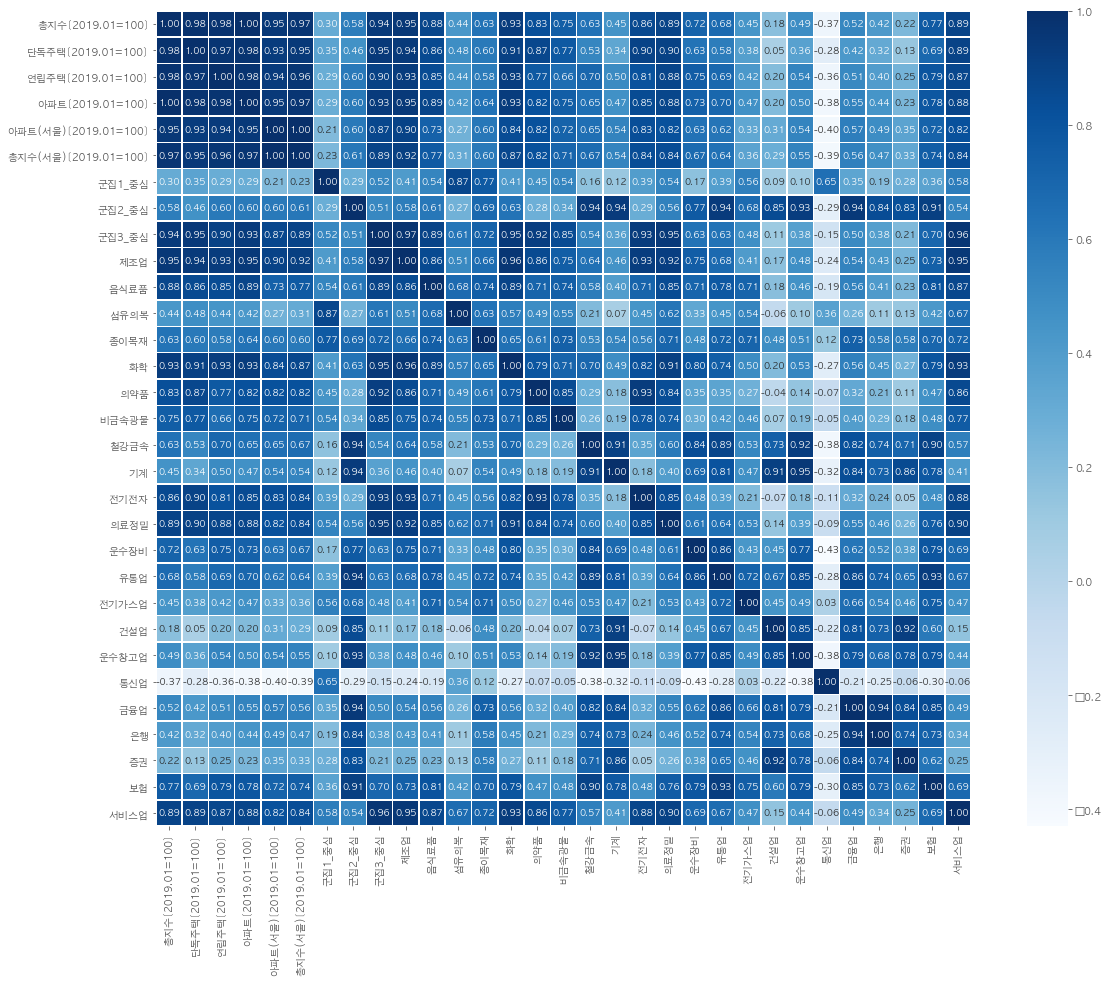

In [45]:
# 전체 데이터 상관관계 분석 결과 heatmap
plt.figure(figsize=(20,15))
corr_heatmap = sns.heatmap(cluster_trading_cor_p, cbar = True, annot = True,
                           linewidths = "0.5", annot_kws={'size' : 9},
                           fmt = '.2f', square = True, cmap = 'Blues')

### 중심값과 주택매매가격지수 상관분석

In [46]:
# 중심값 결과 데이터와 주택매매가격지수 데이터 통합
center_cluster_trading = pd.concat([trading, center_result], axis=1)
center_cluster_trading.head()

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100],군집1_중심,군집2_중심,군집3_중심
날짜,,,,,,,,,
2000-01-01,48.819,72.153,56.103,39.474,31.660,39.451,3.001572,-0.849940,-0.972535
2000-02-01,49.027,72.236,56.231,39.783,32.136,39.782,2.486401,-1.167639,-0.942972
2000-03-01,49.234,72.319,56.615,40.015,32.433,40.114,2.476201,-1.234568,-0.970734
2000-04-01,49.286,72.236,56.679,40.092,32.433,40.238,1.260472,-1.408181,-1.103688
2000-05-01,49.234,72.153,56.615,40.015,32.403,40.238,1.153880,-1.463478,-1.171049


In [47]:
# 중심값 결과 데이터와 주택매매가격지수 데이터 상관분석
center_cluster_trading_cor = center_cluster_trading.corr()
center_cluster_trading_cor = center_cluster_trading_cor.apply(lambda x: round(x, 2))
center_cluster_trading_cor

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100],군집1_중심,군집2_중심,군집3_중심
총지수[2019.01=100],1.00,0.98,0.98,1.00,0.95,0.97,0.30,0.58,0.94
단독주택[2019.01=100],0.98,1.00,0.97,0.98,0.93,0.95,0.35,0.46,0.95
연립주택[2019.01=100],0.98,0.97,1.00,0.98,0.94,0.96,0.29,0.60,0.90
아파트[2019.01=100],1.00,0.98,0.98,1.00,0.95,0.97,0.29,0.60,0.93
아파트(서울)[2019.01=100],0.95,0.93,0.94,0.95,1.00,1.00,0.21,0.60,0.87
총지수(서울)[2019.01=100],0.97,0.95,0.96,0.97,1.00,1.00,0.23,0.61,0.89
군집1_중심,0.30,0.35,0.29,0.29,0.21,0.23,1.00,0.29,0.52
군집2_중심,0.58,0.46,0.60,0.60,0.60,0.61,0.29,1.00,0.51
군집3_중심,0.94,0.95,0.90,0.93,0.87,0.89,0.52,0.51,1.00


In [48]:
# 중심값 결과 데이터와 주택매매가격지수 데이터 상관분석(피어슨 상관관계 분석)
center_cluster_trading_cor_p = center_cluster_trading.corr(method = 'pearson')
center_cluster_trading_cor_p

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100],군집1_중심,군집2_중심,군집3_중심
총지수[2019.01=100],1.000000,0.984761,0.982655,0.998703,0.951107,0.969822,0.304602,0.577523,0.939079
단독주택[2019.01=100],0.984761,1.000000,0.968155,0.976423,0.927888,0.948261,0.352741,0.462759,0.948262
연립주택[2019.01=100],0.982655,0.968155,1.000000,0.975979,0.935389,0.962528,0.290891,0.600833,0.903892
아파트[2019.01=100],0.998703,0.976423,0.975979,1.000000,0.949111,0.966607,0.294536,0.596396,0.934585
아파트(서울)[2019.01=100],0.951107,0.927888,0.935389,0.949111,1.000000,0.996093,0.207251,0.601709,0.872526
총지수(서울)[2019.01=100],0.969822,0.948261,0.962528,0.966607,0.996093,1.000000,0.226831,0.607573,0.889417
군집1_중심,0.304602,0.352741,0.290891,0.294536,0.207251,0.226831,1.000000,0.288638,0.518438
군집2_중심,0.577523,0.462759,0.600833,0.596396,0.601709,0.607573,0.288638,1.000000,0.514387
군집3_중심,0.939079,0.948262,0.903892,0.934585,0.872526,0.889417,0.518438,0.514387,1.000000


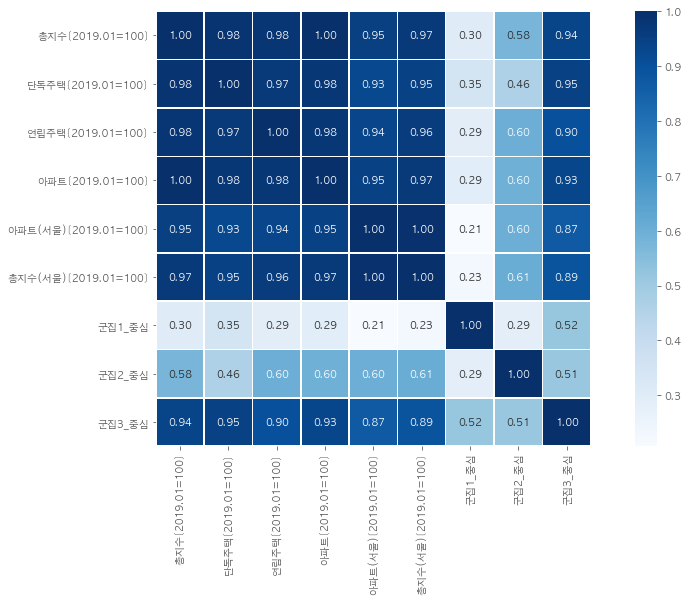

In [49]:
# 전체 데이터 상관관계 분석 결과 heatmap
plt.figure(figsize=(16,8))
corr_heatmap = sns.heatmap(center_cluster_trading_cor_p, cbar = True, annot = True,
                           linewidths = "0.5", annot_kws={'size' : 10},
                           fmt = '.2f', square = True, cmap = 'Blues')

- 위의 두 상관분석 결과를 통해, 군집3에 속한 산업군의 KOSPI 지수 경향성이 주택매매가격지와 상관관계가 가장 높은 것을 확인할 수 있습니다.

### 상관분석 결과 전처리 및 저장

태블로 사용에 적합한 데이터 형태로 변환하여 저장합니다.

#### 전체 종목과 주택매매가격

In [50]:
cluster_trading_cor.columns

Index(['총지수[2019.01=100]', '단독주택[2019.01=100]', '연립주택[2019.01=100]',
       '아파트[2019.01=100]', '아파트(서울)[2019.01=100]', '총지수(서울)[2019.01=100]',
       '군집1_중심', '군집2_중심', '군집3_중심', '제조업', '음식료품', '섬유의복', '종이목재', '화학',
       '의약품', '비금속광물', '철강금속', '기계', '전기전자', '의료정밀', '운수장비', '유통업', '전기가스업',
       '건설업', '운수창고업', '통신업', '금융업', '은행', '증권', '보험', '서비스업'],
      dtype='object')

In [51]:
# 변수명 저장
columns = [['총지수[2019.01=100]'], ['단독주택[2019.01=100]'], ['연립주택[2019.01=100]'],
       ['아파트[2019.01=100]'], ['아파트(서울)[2019.01=100]'], ['총지수(서울)[2019.01=100]'],
       ['군집1_중심'], ['군집2_중심'], ['군집3_중심'], ['제조업'], ['음식료품'], ['섬유의복'], ['종이목재'], ['화학'],
       ['의약품'], ['비금속광물'], ['철강금속'], ['기계'], ['전기전자'], ['의료정밀'], ['운수장비'], ['유통업'], ['전기가스업'],
       ['건설업'], ['운수창고업'], ['통신업'], ['금융업'], ['은행'], ['증권'], ['보험'], ['서비스업']]

In [52]:
# 각 변수마다 31개(변수 수)씩 값을 생성
col_1 = []

for i in range(0, 31):
  col_1.append(columns[i]*31)

In [53]:
col_1 = sum(col_1, [])
col_1[0:10]

['총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]']

In [54]:
# 길이 확인
len(col_1)

961

In [55]:
col_2 = sum(columns*31,[])
col_2[0:10]

['총지수[2019.01=100]',
 '단독주택[2019.01=100]',
 '연립주택[2019.01=100]',
 '아파트[2019.01=100]',
 '아파트(서울)[2019.01=100]',
 '총지수(서울)[2019.01=100]',
 '군집1_중심',
 '군집2_중심',
 '군집3_중심',
 '제조업']

In [56]:
# 길이 확인
len(col_2)

961

In [57]:
# 상관계수 값
value = sum(cluster_trading_cor.values.tolist(),[])
value[0:10]

[1.0, 0.98, 0.98, 1.0, 0.95, 0.97, 0.3, 0.58, 0.94, 0.95]

In [58]:
# 길이 확인
len(value)

961

In [59]:
# 데이터프레임 생성
cor_total_result = pd.DataFrame()
cor_total_result['구분1'] = col_1
cor_total_result['구분2'] = col_2
cor_total_result['값'] = value

In [60]:
cor_total_result.head()

,구분1,구분2,값
0,총지수[2019.01=100],총지수[2019.01=100],1.00
1,총지수[2019.01=100],단독주택[2019.01=100],0.98
2,총지수[2019.01=100],연립주택[2019.01=100],0.98
3,총지수[2019.01=100],아파트[2019.01=100],1.00
4,총지수[2019.01=100],아파트(서울)[2019.01=100],0.95


In [61]:
# 상관분석 결과 저장
cluster_trading_cor.to_csv("./cor_total_result.csv")

#### 전체 종목과 주택매매가격(피어슨)

In [62]:
# 상관계수 값
value_p = sum(cluster_trading_cor_p.values.tolist(),[])
value_p[0:10]

[1.0,
 0.9847607598011333,
 0.9826553912636118,
 0.9987027074232405,
 0.951106703847821,
 0.9698217182113965,
 0.30460191039791684,
 0.5775228565048836,
 0.9390785542958817,
 0.9508338832770618]

In [63]:
# 데이터 프레임 생성
cor_total_result_p = pd.DataFrame()
cor_total_result_p['구분1'] = col_1
cor_total_result_p['구분2'] = col_2
cor_total_result_p['값'] = value_p
cor_total_result_p.head()

,구분1,구분2,값
0,총지수[2019.01=100],총지수[2019.01=100],1.000000
1,총지수[2019.01=100],단독주택[2019.01=100],0.984761
2,총지수[2019.01=100],연립주택[2019.01=100],0.982655
3,총지수[2019.01=100],아파트[2019.01=100],0.998703
4,총지수[2019.01=100],아파트(서울)[2019.01=100],0.951107


In [64]:
# 피어슨 상관분석 결과 저장
cluster_trading_cor_p.to_csv("./cor_total_result_p.csv")

#### 중심값과 주택매매가격

In [65]:
center_cluster_trading_cor.columns

Index(['총지수[2019.01=100]', '단독주택[2019.01=100]', '연립주택[2019.01=100]',
       '아파트[2019.01=100]', '아파트(서울)[2019.01=100]', '총지수(서울)[2019.01=100]',
       '군집1_중심', '군집2_중심', '군집3_중심'],
      dtype='object')

In [66]:
# 변수명 저장
columns2 = [['총지수[2019.01=100]'], ['단독주택[2019.01=100]'], ['연립주택[2019.01=100]'],
       ['아파트[2019.01=100]'], ['아파트(서울)[2019.01=100]'], ['총지수(서울)[2019.01=100]'],
       ['군집1_중심'], ['군집2_중심'], ['군집3_중심']]

In [67]:
# 각 변수마다 9개(변수 수)씩 값을 생성
col2_1 = []

for i in range(0, 9):
  col2_1.append(columns2[i]*9)

In [68]:
col2_1 = sum(col2_1, [])
col2_1[0:10]

['총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '총지수[2019.01=100]',
 '단독주택[2019.01=100]']

In [69]:
# 길이 확인
len(col2_1)

81

In [70]:
col2_2 = sum(columns2*9,[])
col2_2[0:10]

['총지수[2019.01=100]',
 '단독주택[2019.01=100]',
 '연립주택[2019.01=100]',
 '아파트[2019.01=100]',
 '아파트(서울)[2019.01=100]',
 '총지수(서울)[2019.01=100]',
 '군집1_중심',
 '군집2_중심',
 '군집3_중심',
 '총지수[2019.01=100]']

In [71]:
# 길이 확인
len(col2_2)

81

In [72]:
# 상관계수 값
value2 = sum(center_cluster_trading_cor.values.tolist(),[])
value2[0:10]

[1.0, 0.98, 0.98, 1.0, 0.95, 0.97, 0.3, 0.58, 0.94, 0.98]

In [73]:
# 길이 확인
len(value2)

81

In [74]:
# 데이터 프레임 생성
cor_result = pd.DataFrame()
cor_result['구분1'] = col2_1
cor_result['구분2'] = col2_2
cor_result['값'] = value2
cor_result

,구분1,구분2,값
0,총지수[2019.01=100],총지수[2019.01=100],1.00
1,총지수[2019.01=100],단독주택[2019.01=100],0.98
2,총지수[2019.01=100],연립주택[2019.01=100],0.98
3,총지수[2019.01=100],아파트[2019.01=100],1.00
4,총지수[2019.01=100],아파트(서울)[2019.01=100],0.95
...,...,...,...
76,군집3_중심,아파트(서울)[2019.01=100],0.87
77,군집3_중심,총지수(서울)[2019.01=100],0.89
78,군집3_중심,군집1_중심,0.52
79,군집3_중심,군집2_중심,0.51


In [75]:
center_cluster_trading_cor

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100],군집1_중심,군집2_중심,군집3_중심
총지수[2019.01=100],1.00,0.98,0.98,1.00,0.95,0.97,0.30,0.58,0.94
단독주택[2019.01=100],0.98,1.00,0.97,0.98,0.93,0.95,0.35,0.46,0.95
연립주택[2019.01=100],0.98,0.97,1.00,0.98,0.94,0.96,0.29,0.60,0.90
아파트[2019.01=100],1.00,0.98,0.98,1.00,0.95,0.97,0.29,0.60,0.93
아파트(서울)[2019.01=100],0.95,0.93,0.94,0.95,1.00,1.00,0.21,0.60,0.87
총지수(서울)[2019.01=100],0.97,0.95,0.96,0.97,1.00,1.00,0.23,0.61,0.89
군집1_중심,0.30,0.35,0.29,0.29,0.21,0.23,1.00,0.29,0.52
군집2_중심,0.58,0.46,0.60,0.60,0.60,0.61,0.29,1.00,0.51
군집3_중심,0.94,0.95,0.90,0.93,0.87,0.89,0.52,0.51,1.00


In [76]:
# 상관분석 결과 저장
cor_result.to_csv("./cor_result.csv")

#### 중심값과 주택매매가격(피어슨)

In [77]:
# 상관계수 값
value2_p = sum(center_cluster_trading_cor_p.values.tolist(),[])
value2_p[0:10]

[1.0,
 0.9847607598011333,
 0.9826553912636118,
 0.9987027074232405,
 0.951106703847821,
 0.9698217182113965,
 0.30460191039791684,
 0.5775228565048836,
 0.9390785542958817,
 0.9847607598011333]

In [78]:
# 데이터 프레임 생성
cor_result_p = pd.DataFrame()
cor_result_p['구분1'] = col2_1
cor_result_p['구분2'] = col2_2
cor_result_p['값'] = value2_p
cor_result_p

,구분1,구분2,값
0,총지수[2019.01=100],총지수[2019.01=100],1.000000
1,총지수[2019.01=100],단독주택[2019.01=100],0.984761
2,총지수[2019.01=100],연립주택[2019.01=100],0.982655
3,총지수[2019.01=100],아파트[2019.01=100],0.998703
4,총지수[2019.01=100],아파트(서울)[2019.01=100],0.951107
...,...,...,...
76,군집3_중심,아파트(서울)[2019.01=100],0.872526
77,군집3_중심,총지수(서울)[2019.01=100],0.889417
78,군집3_중심,군집1_중심,0.518438
79,군집3_중심,군집2_중심,0.514387


In [79]:
center_cluster_trading_cor_p

,총지수[2019.01=100],단독주택[2019.01=100],연립주택[2019.01=100],아파트[2019.01=100],아파트(서울)[2019.01=100],총지수(서울)[2019.01=100],군집1_중심,군집2_중심,군집3_중심
총지수[2019.01=100],1.000000,0.984761,0.982655,0.998703,0.951107,0.969822,0.304602,0.577523,0.939079
단독주택[2019.01=100],0.984761,1.000000,0.968155,0.976423,0.927888,0.948261,0.352741,0.462759,0.948262
연립주택[2019.01=100],0.982655,0.968155,1.000000,0.975979,0.935389,0.962528,0.290891,0.600833,0.903892
아파트[2019.01=100],0.998703,0.976423,0.975979,1.000000,0.949111,0.966607,0.294536,0.596396,0.934585
아파트(서울)[2019.01=100],0.951107,0.927888,0.935389,0.949111,1.000000,0.996093,0.207251,0.601709,0.872526
총지수(서울)[2019.01=100],0.969822,0.948261,0.962528,0.966607,0.996093,1.000000,0.226831,0.607573,0.889417
군집1_중심,0.304602,0.352741,0.290891,0.294536,0.207251,0.226831,1.000000,0.288638,0.518438
군집2_중심,0.577523,0.462759,0.600833,0.596396,0.601709,0.607573,0.288638,1.000000,0.514387
군집3_중심,0.939079,0.948262,0.903892,0.934585,0.872526,0.889417,0.518438,0.514387,1.000000


In [80]:
# 상관분석 결과 저장
cor_result_p.to_csv("./cor_result_p.csv")